# Goal

Chris Lintott, David O'Ryan and myself (Tobias Géron) spent 5 nights on the INT at the end of September 2022. However, due to storm Hermine, we were only able to observe one target. We were also able to take multiple calibration frames. The target, which is a strongly barred galaxy, was observed with the INT using the IDS spectrograph. We used the R300V grating and the EEV10 detector. We observed the target using a slit placed parallel to the bar and a slit placed perpendicular to the bar. 

The SDSS objid of the target is 587727223561584734  
RA: 00 05 24.1267  
DEC: +16 02 59.9322  

In this notebook, I will go through the different steps in the data reduction using the ccdproc library in Python. I visualise every step along the way.



Useful links:    
ccdproc: https://ccdproc.readthedocs.io/en/latest/  
Other repo that does INT reduction: https://github.com/aayush3009/INT-IDS-DataReduction  




A note on the different files:  
The images are stored under data_telescope/20220923/.  
On-bar science images: 1633271, 1633274, 1633275, 1633276  
Off-bar science images: 1633277, 1633279, 1633280, 1633281  
Bias frames: 1633188 to 1633208  
Flatfields: 1633209 to 1633219  
Arcs: 1633221 to 1633233




# Imports

In [1]:
import numpy as np 
from astropy.io import fits 
from astropy.convolution import Gaussian1DKernel, convolve
from matplotlib import pylab as plt
from astropy.stats import sigma_clip
import pandas as pd
from astropy import units as u
import numpy as np
from astropy.nddata import CCDData
import ccdproc

# Definitions

In [2]:
def load_data(files):
    '''
    Takes file locations, will open them and return the data
    '''
    datas = []
    for file in files:
        f = fits.open(file)
        datas.append(f[1].data)
        
    return datas
    
def average_data(datas):
    '''
    Will average all data in list
    '''
    return np.mean(datas, axis = 0)
    
def normalise_data(datas):
    normalised = []
    for data in datas:
        normalised.append(data / np.mean(data))
    return normalised

def plot_ccd(data,figsize = (7,12), perc = 5, axvlines = []):
    data = np.array(data)
    lam,slit = data.shape
    mid = slit/2
    
    plt.figure(figsize = figsize)

    plt.pcolormesh(data, vmin = np.nanpercentile(data,perc), vmax = np.nanpercentile(data,100-perc))
    plt.colorbar()
    plt.ylabel('Wavelength [pix]')
    plt.xlabel('Position along slit [pix]')
    plt.title('Raw data')
    
    for axv in axvlines:
        plt.axvline(mid+axv, c='r', lw = 1)

    plt.show()
    


def plot_estimated_spectrum(data,window = [-5,5],ylims_override = [],xlims_override = [], stdev = 10,
                            axvlines = [], figsize = (12,5), plot_smooth = True, sigma_clipping = 5, 
                            xaxis = [],xlab = 'Wavelength [pix]', ylab = 'Signal', title = '',
                           savefig = ''):
    data = np.array(data)
    
    if len(data.shape) > 1:
        gal = extract_spectrum(data,window)
        if xaxis == []:
            lam,slit = data.shape
            xaxis = range(lam)[::-1]
    else: #means spectrum already extracted
        gal = data
        if xaxis == []:
            xaxis = range(len(data))[::-1]
    
    if type(sigma_clipping) == int:
        galclip = sigma_clip(gal, sigma=sigma_clipping, maxiters=1) # Smooth the spectrum
    else:
        galclip = gal
    gauss = Gaussian1DKernel(stddev=stdev)
    galsmooth = convolve(galclip, gauss)
    
    plt.figure(figsize = figsize)
    plt.plot(xaxis,galclip,c='black')
    if plot_smooth:
        plt.plot(xaxis,galsmooth,c='r')
    
    plt.xlabel(xlab, fontsize = 16)
    plt.xticks(fontsize=14)
    plt.ylabel(ylab, fontsize = 16)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize = 18)
    
    plt.ylim(np.nanpercentile(galclip,1),np.nanpercentile(galclip,100))
    if ylims_override != []:
        plt.ylim(ylims_override[0],ylims_override[1])
        
    if xlims_override != []:
        plt.xlim(xlims_override[0],xlims_override[1])
        
    for axv in axvlines:
        plt.axvline(axv, c='r', lw = 1, ls = '--')
    
    
    if savefig != '':
        plt.savefig(savefig,bbox_inches = 'tight',transparent=False,dpi=300,facecolor='white') 
    plt.show()
    
    
def extract_spectrum(data, window = [-5,5]):
    data = np.array(data)
    lam,slit = data.shape
    mid = slit/2
    gal = np.sum(data[:, int(mid+window[0]):int(mid+window[1])].astype(float), axis=1)/(window[1] - window[0]) # I would think to average, not sum? Guess it doesn't matter. y-axis just scales
    return gal

def snr(wavelength, smooth ,raw, target = 6564, window = 100):
    """
    Window is on each side. Units are in A.
    Either wavelengths should all be in rest, or all in observed.
    
    Is the noise on one side or on two?
    """
    target_min, target_max = target + window, target - window #the axis reversed
    
    _, idx_min = find_closest(wavelength, target_min)
    _, idx_max = find_closest(wavelength, target_max)
    
    noise = np.mean(np.abs(raw - smooth))
    signal = np.percentile(smooth[idx_min:idx_max],99)
    return signal/noise, signal, noise

def find_closest(lst, i):
    """
    Find the item closest to i in lst. If multiple, returns one of them
    """
    
    diff = np.abs(np.array(lst) - i)
    idx = np.where(diff == np.min(diff))[0][0]
    return lst[idx],idx

# Load different images

In [3]:
# Science images
base_dir = 'data_telescope/20220923/'
file_numbers = ['1633271','1633274','1633275','1633276'] #on bar
#file_numbers = ['1633277','1633279','1633280','1633281']# off bar
files = [f'{base_dir}r{i}.fit' for i in file_numbers]
master_science = average_data(load_data(files))
header = fits.open(files[0])[0].header

# Bias images
base_dir = 'data_telescope/20220923/'
file_numbers = np.arange(1633188,1633208+1)
files = [f'{base_dir}r{i}.fit' for i in file_numbers]
master_bias = average_data(load_data(files))

# Flat images
base_dir = 'data_telescope/20220923/'
file_numbers = np.arange(1633209,1633219+1)
files = [f'{base_dir}r{i}.fit' for i in file_numbers]
master_flat = average_data(load_data(files)) #ccdproc normalises flat automatically

# Arc image
base_dir = 'data_telescope/20220923/'
file_numbers = [1633221]
files = [f'{base_dir}r{i}.fit' for i in file_numbers]
arc = average_data(load_data(files))



# Constants https://www.ing.iac.es//Engineering/detectors/ultra_eev10a.htm
gain = 1.2 #e/ADU
readnoise = 5 #e

# Data Reduction

### Look at raw data

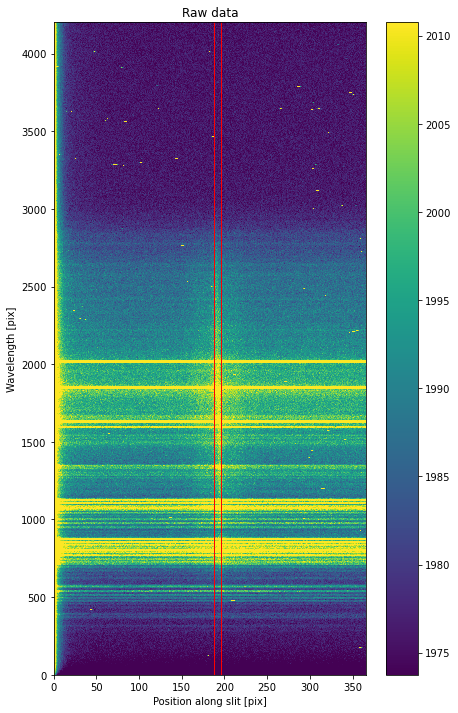

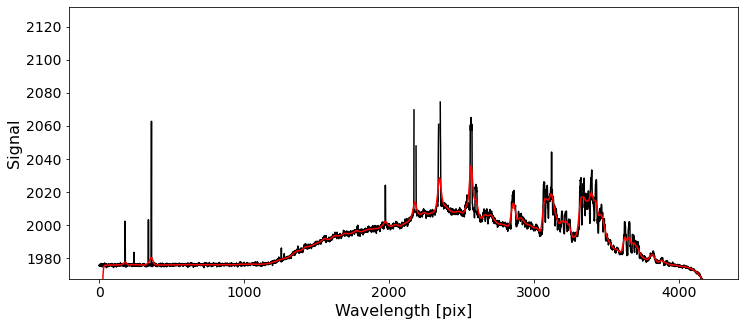

In [4]:
data = CCDData(master_science, unit=u.adu)
window = [5,13] #ideal window for on-bar 
#window = [10,18] #ideal window for off-bar
plot_ccd(data, axvlines = window)
plot_estimated_spectrum(data, window = window)

# Note: the window selected here is used here to plot the spectrum.

### Apply uncertainty

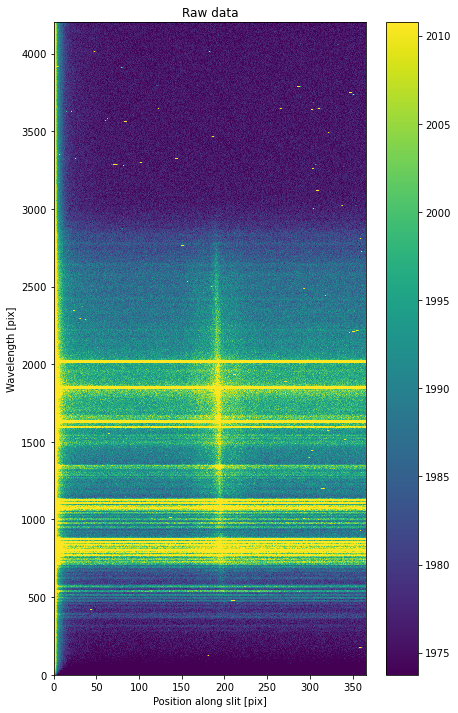

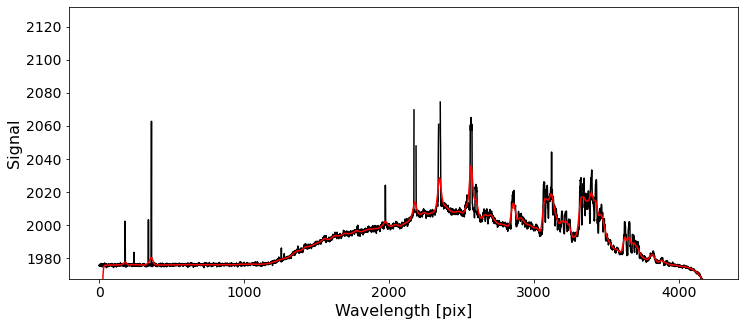

In [5]:
data = ccdproc.create_deviation(data, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
plot_ccd(data)
plot_estimated_spectrum(data, window = window)

### Apply gain correction

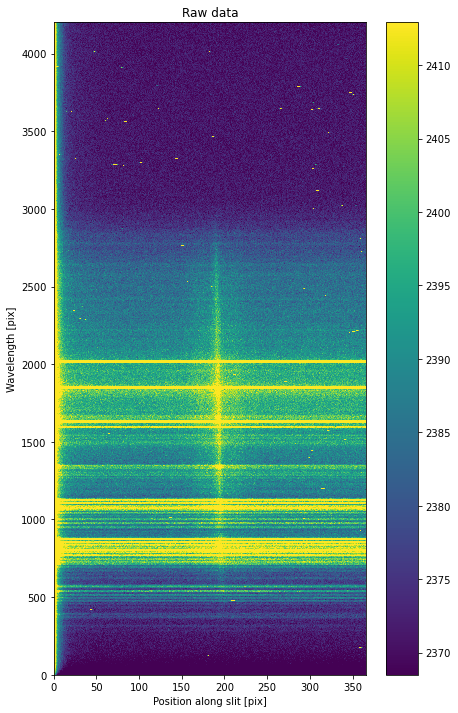

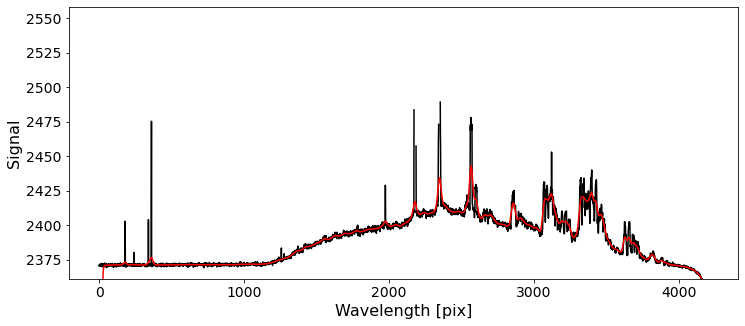

In [6]:
data = ccdproc.gain_correct(data, gain*u.electron/u.adu)
plot_ccd(data)
plot_estimated_spectrum(data, window = window)

### Subtract overscan

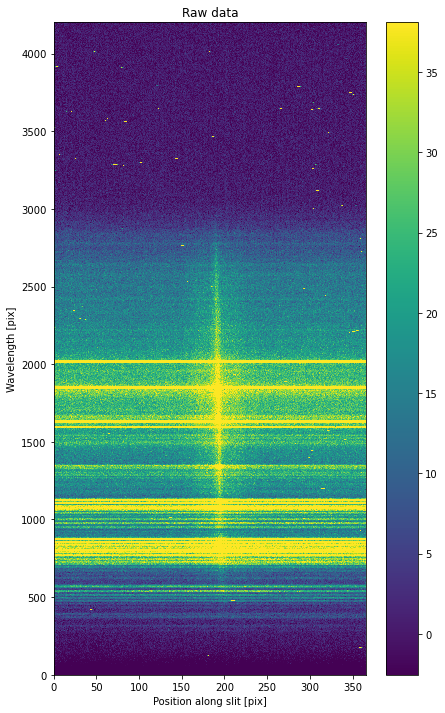

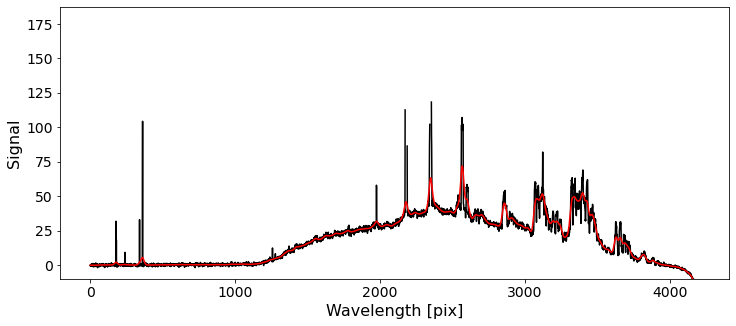

In [7]:
data = ccdproc.subtract_overscan(data, median=True,  overscan_axis=0, overscan=data[4110:4190,:])
plot_ccd(data)
plot_estimated_spectrum(data, window = window)

### Trim image

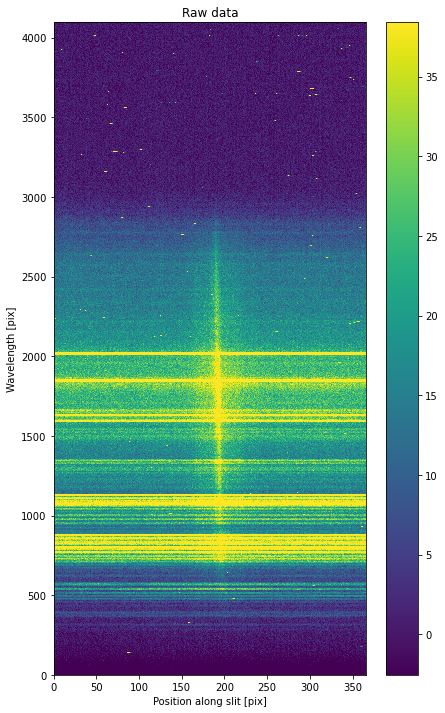

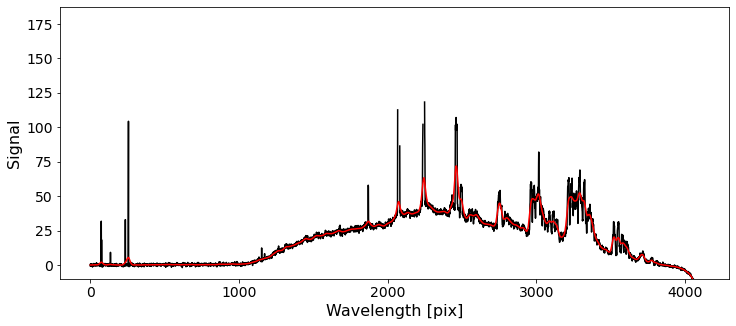

In [8]:
data = ccdproc.trim_image(data[:4096,:])
plot_ccd(data)
plot_estimated_spectrum(data, window = window)

### Subtract bias

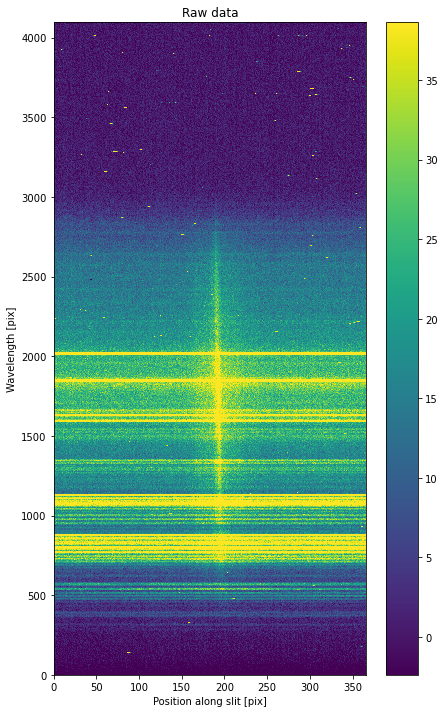

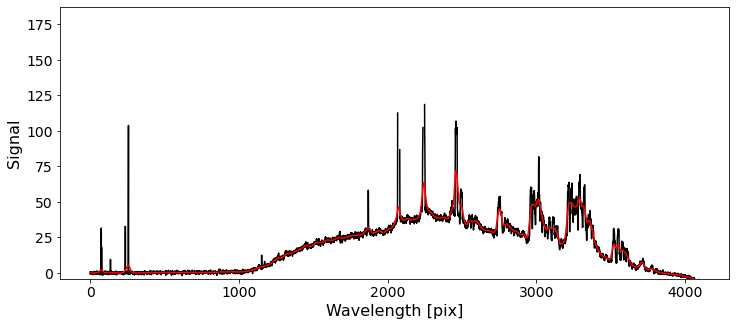

In [9]:
master_bias = CCDData(master_bias, unit=u.adu)
master_bias = ccdproc.gain_correct(master_bias, gain*u.electron/u.adu)
master_bias = ccdproc.subtract_overscan(master_bias, median=True,  overscan_axis=0, overscan=master_bias[4110:4190,:])
master_bias = ccdproc.trim_image(master_bias[:4096,:])

data = ccdproc.subtract_bias(data, master_bias)
plot_ccd(data)
plot_estimated_spectrum(data, window = window)

### Flatfield correction

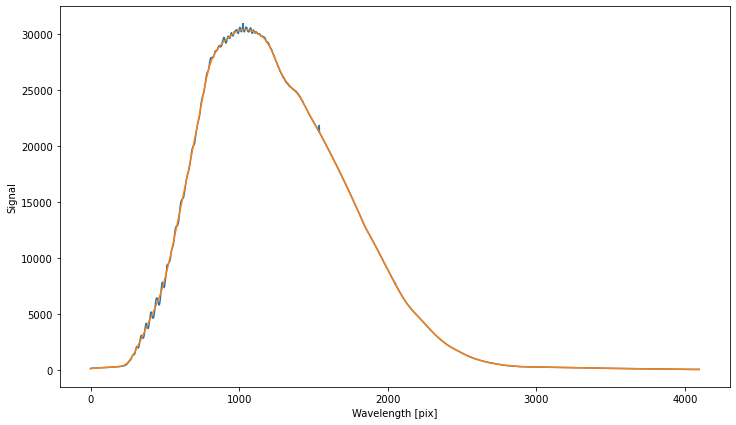

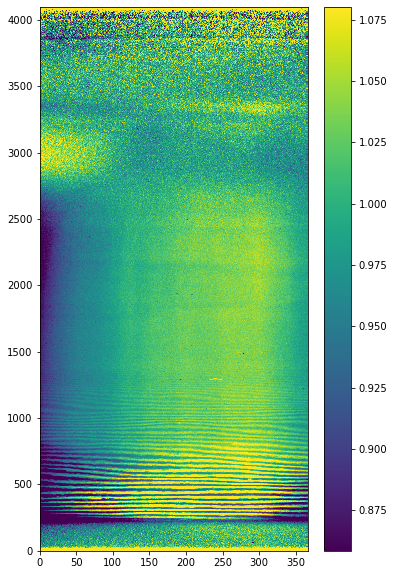

In [10]:
# http://www.starlink.ac.uk/docs/sc7.htx/sc7se4.html#x5-200016

master_flat = CCDData(master_flat, unit=u.adu)
master_flat = ccdproc.create_deviation(master_flat, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
master_flat = ccdproc.gain_correct(master_flat, gain*u.electron/u.adu)
master_flat = ccdproc.subtract_overscan(master_flat, median=True,  overscan_axis=0, overscan=master_flat[4110:4190,:])
master_flat = ccdproc.trim_image(master_flat[:4096,:])
master_flat = ccdproc.subtract_bias(master_flat, master_bias) 

# Visualise flatfield
plt.figure(figsize = (12,7))
summed_flat = np.average(master_flat, axis = 1) # average the flat over spatial axis
gauss = Gaussian1DKernel(stddev=20)
smooth_flat = convolve(summed_flat, gauss)
plt.plot(range(len(summed_flat)),summed_flat)
plt.plot(range(len(summed_flat)), smooth_flat)
plt.xlabel('Wavelength [pix]')
plt.ylabel('Signal')
plt.show()


master_flat = ((np.array(master_flat).T / smooth_flat)).T
master_flat = master_flat / np.mean(master_flat)
master_flat = CCDData(master_flat, unit=u.electron)



plt.figure(figsize = (6,10))
plt.pcolormesh(master_flat,vmin = np.percentile(master_flat,2),vmax = np.percentile(master_flat,95))
plt.colorbar()
plt.show()

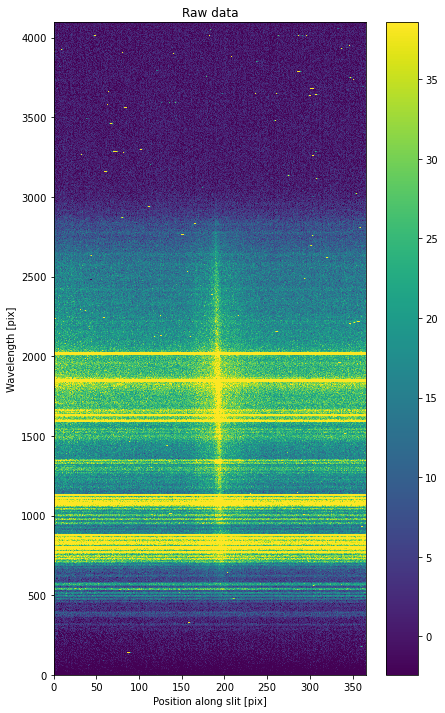

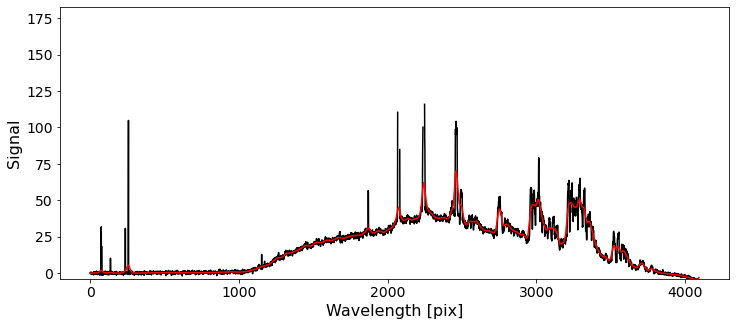

In [11]:
# Apply flatfield

data = ccdproc.flat_correct(data, master_flat, min_value=0.01)

plot_ccd(data)
plot_estimated_spectrum(data, window = window)

### Sky subtraction

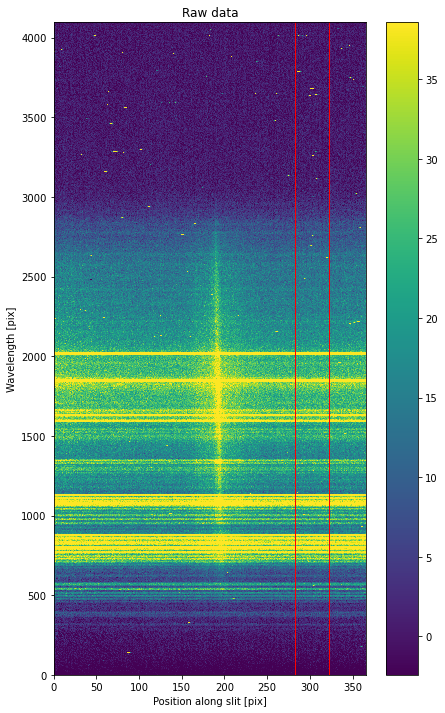

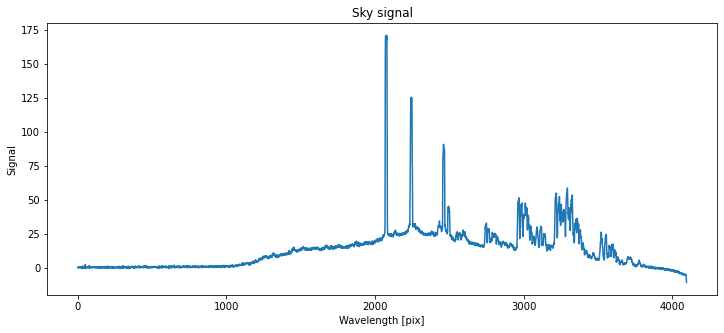

In [12]:
sky_window = [100,140] #selection window for sky subtraction

plot_ccd(data, axvlines = sky_window)

lam,slit = data.shape
mid = slit/2
sky = data[:,int(mid+sky_window[0]):int(mid+sky_window[1])]
sky = np.median(sky,axis = 1)

plt.figure(figsize = (12,5))
plt.plot(range(len(sky))[::-1],sky)
plt.xlabel('Wavelength [pix]')
plt.ylabel('Signal')
plt.title('Sky signal')
plt.show()

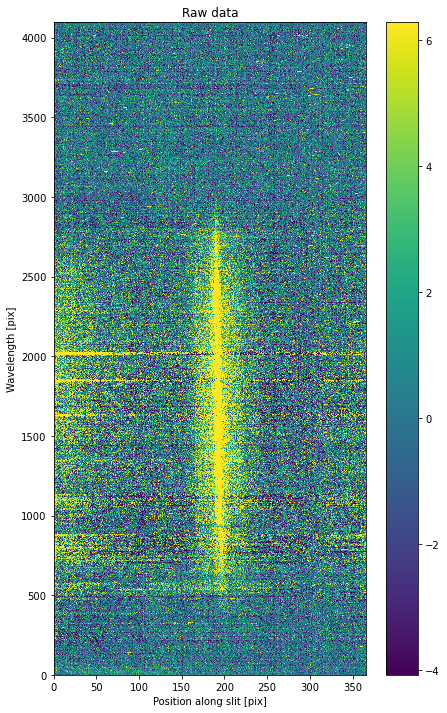

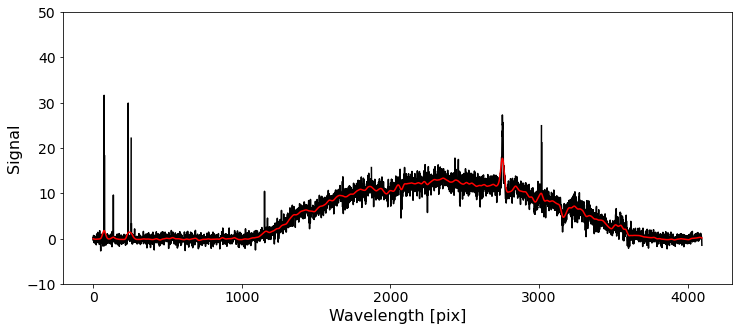

In [13]:
# Apply sky subtraction

data = (np.array(data).T - np.array(sky)).T
data = CCDData(data, unit=u.electron)

plot_ccd(data)
plot_estimated_spectrum(data, window = window,ylims_override = [-10,50])

### Normalisation / Blaze correction
See e.g. : http://www.starlink.ac.uk/docs/sc7.htx/sc7se4.html#x5-200016 

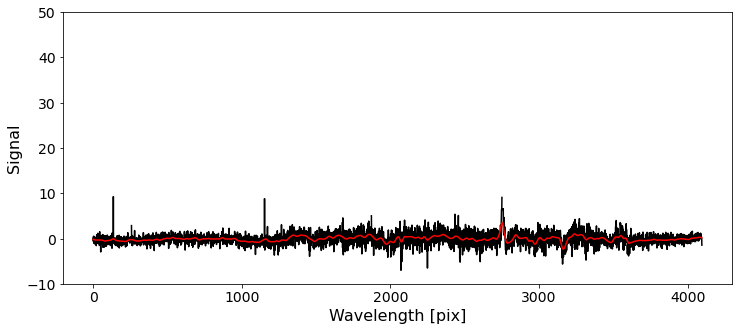

In [14]:
spectrum = extract_spectrum(data,window)
stdev = 150
gauss = Gaussian1DKernel(stddev=stdev)
blaze = convolve(spectrum, gauss)
spectrum = spectrum - blaze

plot_estimated_spectrum(spectrum, window = window, ylims_override = [-10,50])

### Apply arcs

I manually went over the different arcs with different exposures and looked at which peaks at which pixel corresponds to which wavelength. I then plot a first order fit through them to estimate the conversion.

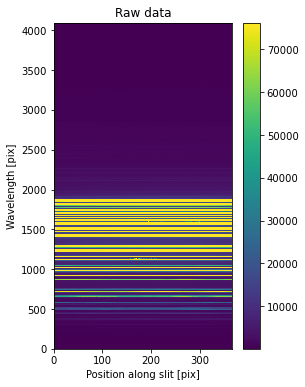

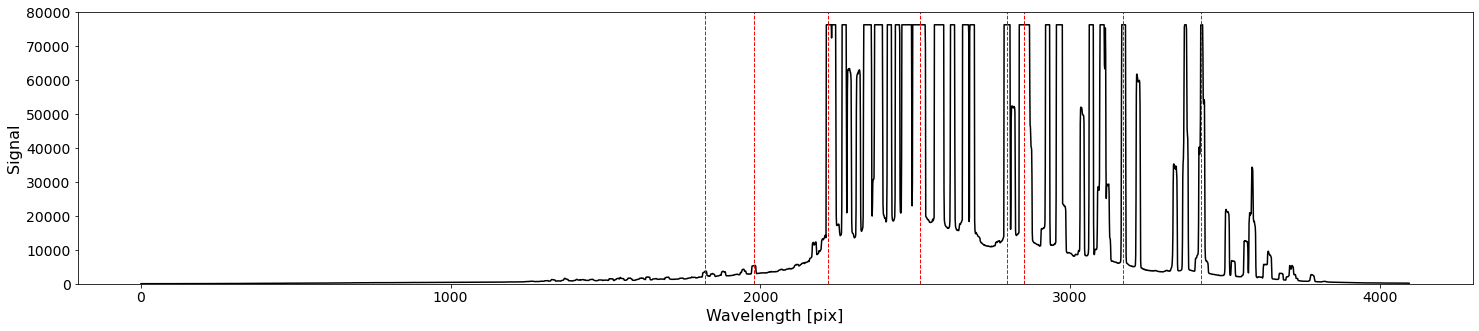

In [15]:
base_dir = 'data_telescope/20220923/'
file_numbers = [1633221]
file_numbers = [1633223]
files = [f'{base_dir}r{i}.fit' for i in file_numbers]
arc = average_data(load_data(files))

arc = CCDData(arc, unit=u.adu)
arc = ccdproc.create_deviation(arc, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
arc = ccdproc.gain_correct(arc, gain*u.electron/u.adu)
arc = ccdproc.subtract_overscan(arc, median=True,  overscan_axis=0, overscan=arc[4110:4190,:])
arc = ccdproc.trim_image(arc[:4096,:])
arc = ccdproc.subtract_bias(arc, master_bias) 

plot_ccd(arc, figsize = (4,6))
plot_estimated_spectrum(arc, window = window,ylims_override = [0,80000], 
                        plot_smooth = False, figsize = (25,5), axvlines = [1821, 1979, 2218, 2514, 2796, 2851, 3172, 3424],
                       sigma_clipping = False)

# Values from https://www.ing.iac.es//astronomy/observing/manuals/ps/tech_notes/tn133.pdf
# 1925 pix corresponds to 5105.54
# 2083 pix corresponds to 5400.56
# 2322 pix corresponds to 5852.49
# 2618 pix corresponds to 6402.25
# 2900 pix corresponds to 6929.47
# 2955 pix corresponds to 7032.41
# 3276 pix corresponds to 7635.11
# 3528 pix corresponds to 8115.13



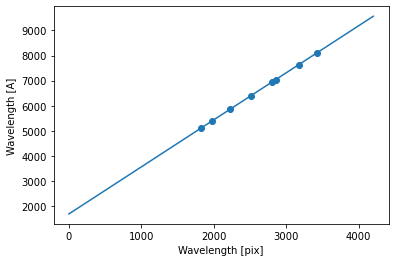

The resolution is 1.87 A/pix.


In [16]:
wavevals = [5105.54,5400.56,5852.49,6402.25,6929.47,7032.41,7635.11,8115.13] #header['CENWAVE']
pixvals = [1821, 1979, 2218, 2514, 2796, 2851, 3172, 3424] #data.shape[0]/2

plt.scatter(pixvals,wavevals)
z = np.polyfit(pixvals,wavevals,1)
p = np.poly1d(z)

xs = np.linspace(0, 4200,100)
plt.plot(xs,p(xs))
plt.xlabel('Wavelength [pix]')
plt.ylabel('Wavelength [A]')
plt.show()

print(f'The resolution is {np.round(z[0],2)} A/pix.')

# It should be 1.87: https://www.ing.iac.es/astronomy/instruments/ids/idsgrat_tables.html

In [17]:
# Apply arc conversion

xaxis_waveobs = p(range(len(spectrum))[::-1])
redshift = 0.0427842 # from sdss
xaxis_waveem = xaxis_waveobs / (1+redshift)


# Final spectrum

/Users/geron/opt/anaconda3/envs/Zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


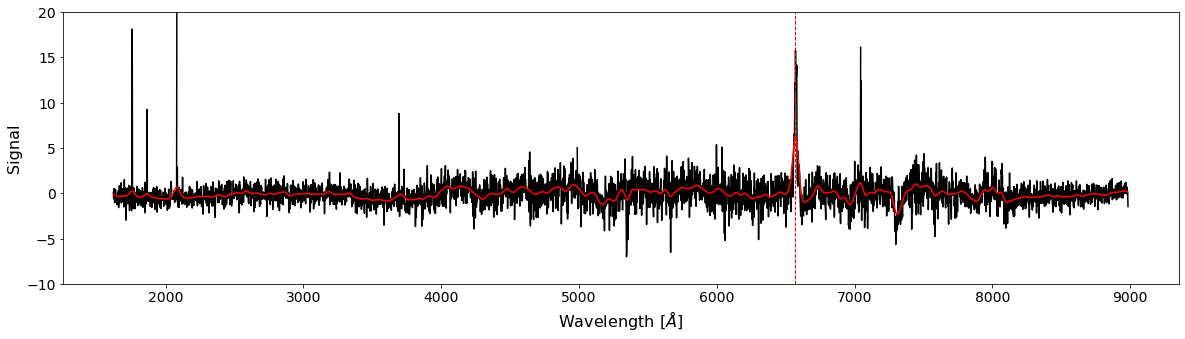

In [18]:

plot_estimated_spectrum(spectrum, window = window, xaxis = xaxis_waveem, ylims_override = [-10,20],
                       axvlines = [6564], figsize = (20,5), xlab = r'Wavelength [$\AA$]', ylab = r'Signal',
                       sigma_clipping = 10, stdev = 10)



### Calculate SNR of Halpha line

/Users/geron/opt/anaconda3/envs/Zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


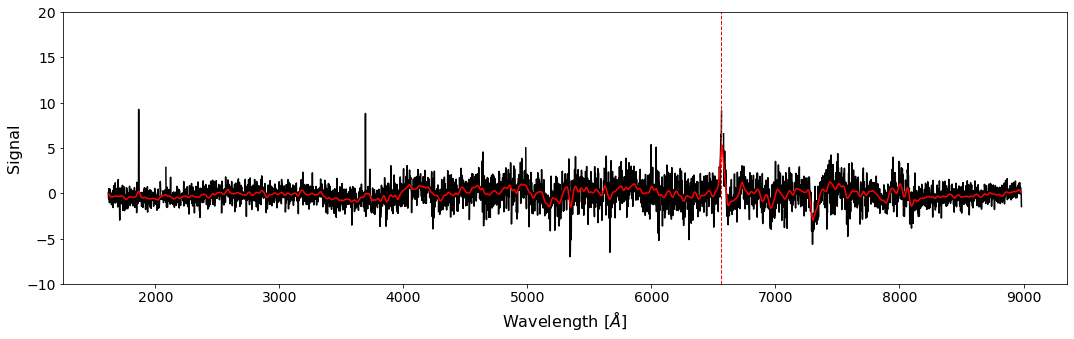

The SNR of Halpha is ~9.24. Signal is ~8.76, noise is ~0.95.


In [19]:
stdev = 6
gauss = Gaussian1DKernel(stddev=stdev)
spectrum_smooth = convolve(spectrum, gauss)

plot_estimated_spectrum(spectrum, window = window, xaxis = xaxis_waveem, stdev = stdev,figsize = (18,5), ylims_override = [-10,20],
                       axvlines = [6564], xlab = r'Wavelength [$\AA$]')

SNR, signal, noise = snr(xaxis_waveem, spectrum_smooth, spectrum, target = 6564, window = 50)
print(f'The SNR of Halpha is ~{np.round(SNR,2)}. Signal is ~{np.round(signal,2)}, noise is ~{np.round(noise,2)}.')